In [1]:
import os
import sys
import cv2
import h5py
import argparse
import numpy as np
from glob import glob
from pathlib import Path
from matplotlib import pyplot as plt
from natsort import natsorted
from tqdm import tqdm
import tifffile

In [2]:
def get_img_paths(img_dir: str, seg_dir: str, source_dir: str, AorB="B", sbp_style: str = True, cycle: bool =True, single: bool =False, img_only: bool = False):
    """ Retrive the path of the synthesized images, source images, and segmentation masks.
        The functions expects to retrive the paths from a cycleGAN styled results directory.  
        If cycle is set to true, the function filter for the fake B images generated by the CycleGAN 
        and retrives the segmentation masks that correspond to the image patches. 
        If cycle is set to false the function retrieves the images and matching seg masks.

        img_dir: path to the image directory (contains the synthesized images as e.g. <#img>_fake_B.png)
        seg_dir: path to the corresponding segmentation patches directory (containing images named <#img>.png)
        source_dir: path to the corresponding source images directory (containing images named <#img>.png)
        AorB: set to B if the paths to all fake B images should be retrived and to A for all fake A image paths
        cycle: if set to true expects synthesized images to be named: <#img>_fake_B.png
        single: if set to true expects synthesized images to be named: <#img>_fake.png
        sbp_style: if set to true expects synthesized images to be named: <slice_nr>_block_<patch_nr>_fake_B.png or <slice_nr>_block_<patch_nr>_fake.png
        img_only: if set to true only expects to process image data, no segmentation masks or source images

        Return:
            The lists containing the paths to the synthesized, segmentation, source paths respectively
    """

    # retrive the paths to all images in img_dir as list
    img_paths = natsorted(glob(img_dir+'*'))
    img_names = []

    if not img_only:
        seg_path = natsorted(glob(seg_dir))[0] 
        source_path = natsorted(glob(source_dir))[0]
        seg_mask_names = []
        source_names = []


    # filter for the fake b images and corresponding seg masks
    for i, ip in enumerate(img_paths):
        if cycle:
            dis = ip.split('/')[-1].split('_')
            if dis[-2:][0] == 'fake':
                if dis[-2:][1] == AorB+'.png':
                    # collect all path that point to syn. images with name <#img>_fake_B.png
                    img_names.append(ip)
                    # collect the corresponding seg. masks and source images named <#img>.png
                    if not img_only:
                        if sbp_style:
                            seg_mask_names.append(os.path.join(seg_path,str(dis[0]) +'_'+ str(dis[1]) +'_'+ str(dis[2]) +'.png'))
                            source_names.append(os.path.join(source_path,str(dis[0]) +'_'+ str(dis[1]) +'_'+ str(dis[2]) +'.png'))
                        else:
                            seg_mask_names.append(os.path.join(seg_path,str(dis[0]) +'_'+ str(dis[1])+'.png'))
                            source_names.append(os.path.join(source_path,str(dis[0]) +'_'+ str(dis[1])+'.png'))
        elif single:
            dis = ip.split('/')[-1].split('_')
            if dis[-1] == 'fake.png':
                # collect all path that point to syn. images with name <#img>_fake_B.png
                img_names.append(ip)
                # c\ollect the corresponding seg. masks and source images named <#img>.png
                if not img_only:
                    if sbp_style:
                        seg_mask_names.append(os.path.join(seg_path,str(dis[0]) +'_'+ str(dis[1]) +'_'+ str(dis[2]) +'.png'))
                        source_names.append(os.path.join(source_path,str(dis[0]) +'_'+ str(dis[1]) +'_'+ str(dis[2]) +'.png'))
                    else:
                        seg_mask_names.append(os.path.join(seg_path,str(dis[0]) +'_'+ str(dis[1])+'.png'))
                        source_names.append(os.path.join(source_path,str(dis[0]) +'_'+ str(dis[1])+'.png'))
        else:
            # if cycle is set to False collect all syn., seg., and source images named <#img>.png
            dis = ip.split('/')[-1]
            img_names.append(ip)
            if not img_only:
                seg_mask_names.append(os.path.join(seg_dir,dis))
                source_names.append(os.path.join(source_dir,dis))
    if not img_only:
        return img_names, seg_mask_names, source_names
    else:
        return img_names

In [3]:
cycle_out_dir = "/n/pfister_lab2/Lab/leander/em2exm/slurm_jobs/submission_ccgan__dorsal_crop_dense__vanilla__20E_15DE/ccgan/results/vanilla__20E_15DE/test_latest/images/"
save_files = "/n/pfister_lab2/Lab/leander/em2exm/slurm_jobs/submission_ccgan__dorsal_crop_dense__vanilla__20E_15DE/"
gt_seg_dir = "/n/pfister_lab2/Lab/leander/em2exm/ccgan/datasets/submission_255_512_512/gt_seg_mask/"
oringin_dir = "/n/pfister_lab2/Lab/leander/em2exm/ccgan/datasets/submission_255_512_512/testA/"
img_names, seg_mask_names, source_names = get_img_paths(cycle_out_dir, gt_seg_dir, oringin_dir, AorB="A", cycle=True, single=False, img_only=False)



In [4]:
print([ img.split("/")[-1] for img in img_names[:18]])

['0_block_0_fake_A.png', '0_block_1_fake_A.png', '0_block_2_fake_A.png', '0_block_3_fake_A.png', '0_block_4_fake_A.png', '0_block_5_fake_A.png', '0_block_6_fake_A.png', '0_block_7_fake_A.png', '0_block_8_fake_A.png', '0_block_9_fake_A.png', '0_block_10_fake_A.png', '0_block_11_fake_A.png', '0_block_12_fake_A.png', '0_block_13_fake_A.png', '0_block_14_fake_A.png', '0_block_15_fake_A.png', '1_block_0_fake_A.png', '1_block_1_fake_A.png']


In [6]:
def create_h5s(img_paths: str, seg_paths: str, source_paths: str, 
                img_file_name: str, seg_file_name: str, source_file_name: str,
                key_img: str = 'main', key_seg: str = 'main', key_source: str = 'main', 
                volume_size: tuple = (255,512,512), block_size=(128,128)) -> None: 
    """ Creates three independent h5 files for the syn. images, seg. masks, and source images.
        The image patches are stored under the key 'main' in all three cases.

        img_paths: list of the paths to the images
        seg_paths: list of paths to the corresponding segmentation patches
        source_paths: list of paths to the corresponding source images
        img_file_name: file name for the h5-file
        seg_file_name: file name for the h5-file
        source_file_name: file name for the h5-file
        key_img: key under which the image patches are stored in the h5 file
        key_seg: key under which the image patches are stored in the h5 file
        key_source: key under which the image patches are stored in the h5 file
        size: tuple of height and width - if set the images get resized before being saved
    """

    PATCH_NR_HEIGHT = int(volume_size[1]//block_size[0])
    PATCH_NR_WIDTH = int(volume_size[2]//block_size[1])
    
    # calculate the number of patches per slice
    nr_patches_height = PATCH_NR_HEIGHT
    nr_patches_width = PATCH_NR_WIDTH
    pp_slice = int((nr_patches_height) * (nr_patches_width))
    
    assert(len(img_paths)/pp_slice==volume_size[0]), "The number of patches and slices do not agree"

    
    # if size is not set retrive the image shape
    if block_size is None:
        block_size = cv2.imread(img_paths[0], cv2.IMREAD_GRAYSCALE).shape
        
    # write one file for each image type
    with h5py.File(img_file_name, "w") as img_patches, \
            h5py.File(source_file_name, 'w') as sou_patches, \
        h5py.File(seg_file_name, "w") as seg_patches:

        # all data types must have the same shape
        img_patches = img_patches.create_dataset(key_img, shape=volume_size, dtype=np.uint8)
        sou_patches = sou_patches.create_dataset(key_source, shape=volume_size, dtype=np.uint8)
        seg_patches = seg_patches.create_dataset(key_seg, shape=volume_size, dtype=int)

        # iterate over the number of slices = number of patches / patches per slice
        for l in tqdm(range(0, int(len(img_paths)/pp_slice))):
            # iterate over the rows
            for i in range(0, nr_patches_height):
                # iterate over the columns - 1, as we concatenate the previous we the next slice in each iteration
                for j in range(0,nr_patches_width):
                    img = cv2.imread(img_paths[(i*(nr_patches_width))+j+pp_slice*l], cv2.IMREAD_GRAYSCALE)
                    sou = cv2.imread(source_paths[(i*(nr_patches_width))+j+pp_slice*l], cv2.IMREAD_GRAYSCALE)
                    seg = cv2.imread(seg_paths[(i*(nr_patches_width))+j+pp_slice*l], cv2.IMREAD_GRAYSCALE)
                    # resize the images
                    if block_size is not None: 
                        img = cv2.resize(img, (block_size[0],block_size[1]))
                        seg = cv2.resize(seg, (block_size[0],block_size[1]))
                        sou = cv2.resize(sou, (block_size[0],block_size[1]))
                    #print(l,int(cfg.BLOCKSIZE[0]*i), int(cfg.BLOCKSIZE[0]*(i+1)),int(cfg.BLOCKSIZE[1]*j),int(cfg.BLOCKSIZE[1]*(j+1)))
                    img_patches[l,int(block_size[0]*i):int(block_size[0]*(i+1)),int(block_size[1]*j):int(block_size[1]*(j+1))] = img.astype(np.uint8)
                    sou_patches[l,int(block_size[0]*i):int(block_size[0]*(i+1)),int(block_size[1]*j):int(block_size[1]*(j+1))] = sou.astype(np.uint8)
                    seg_patches[l,int(block_size[0]*i):int(block_size[0]*(i+1)),int(block_size[1]*j):int(block_size[1]*(j+1))] = seg
                    #merged_masks[l,int(cfg.BLOCKSIZE[0]*i):int(cfg.BLOCKSIZE[0]*(i+1)),int(cfg.BLOCKSIZE[1]*j):int(cfg.BLOCKSIZE[1]*(j+1))] = stack[(i*(nr_patches_width))+j+pp_slice*l, :, :] 


In [7]:
create_h5s(img_names, seg_mask_names, source_names, os.path.join(save_files,"seg_exm2em_f0_img_patches_vol2.hdf5"), os.path.join(save_files, "seg_em2exm_f0_seg_patches.hdf5"), os.path.join(save_files,"seg_em2exm_f0_source_patches.hdf5") )





100%|██████████| 255/255 [01:57<00:00,  2.18it/s]


In [15]:
def check_h5(path_h5_imgs: str, path_h5_segs: str, path_h5_source: str, 
            key_img: str = 'main', key_seg: str = 'main', key_source: str = 'main') -> bool:
    """ Check that the three h5-files got correctly created

        path_h5_imgs: path to the h5-file containing the syn. images
        path_h5_segs: path to the h5-file containing the seg. images
        path_h5_source: path to the h5-file containing the source images
        key_img: key under which the image patches are stored in the h5 file
        key_seg: key under which the image patches are stored in the h5 file
        key_source: key under which the image patches are stored in the h5 file
    """
    # check that 5h-files got created/exist
    assert Path(path_h5_imgs).exists(), "The h5-file for the syn. images does not exist"
    assert Path(path_h5_segs).exists(), "The h5-file for the seg. masks does not exist"
    assert Path(path_h5_source).exists(), "The h5-file for the source images does not exist"

    # read the three files
    with h5py.File(path_h5_imgs, "r") as images,\
     h5py.File(path_h5_segs, "r") as segmasks, \
     h5py.File(path_h5_source, "r") as source:
        
        # check that the keys are correct 
        try:
            imgs = images.get(key_img)
            segs = segmasks.get(key_seg)
            sou = source.get(key_source)
        except AttributeError as e:
            raise "A key does not match the corresponding h5 file - an exception occurred: {}".format(e)

        # check that the stored data is not an empty list
        assert (imgs is not None and len(imgs) > 0), "The data set for key \"{0}\" in \"{1}\" is either empty or None".format(key_img, path_h5_imgs)
        assert (segs is not None and len(segs) > 0), "The data set for key \"{0}\" in \"{1}\" is either empty or None".format(key_seg, path_h5_segs)
        assert (sou is not None and len(sou) > 0), "The data set for key \"{0}\" in \"{1}\" is either empty or None".format(key_source, path_h5_source)
        assert (imgs.shape == segs.shape and sou.shape == sou.shape), f"Shapes do not match, imgs is {img.shape}, segs is {segs.shape}, sou is {sou.shape}"
        assert (imgs.dtype == np.uint8 and segs.dtype == np.int64 and sou.dtype == np.uint8), f"dtype do not match, imgs is {imgs.dtype}, segs is {segs.dtype}, sou is {sou.dtype}"

        print(imgs.shape, segs.shape, sou.shape)


In [16]:
check_h5(os.path.join(save_files,"seg_exm2em_f0_img_patches_vol2.hdf5"), os.path.join(save_files, "seg_em2exm_f0_seg_patches.hdf5"), os.path.join(save_files,"seg_em2exm_f0_source_patches.hdf5") )

(255, 512, 512) (255, 512, 512) (255, 512, 512)


In [17]:
def visual_check_h5s(path_h5_imgs: str, path_h5_segs: str, path_h5_source: str,
                key_img: str = 'main', key_seg: str = 'main', key_source: str = 'main') -> None:
    """ Visual check of the three h5 files by plotting a selection of the stored data.

        path_h5_imgs: path to the h5-file containing the syn. images
        path_h5_segs: path to the h5-file containing the seg. images
        path_h5_source: path to the h5-file containing the source images
        target_dir: path where to save the figure
        figure_name: name of for the figure
        key_img: key under which the image patches are stored in the h5 file
        key_seg: key under which the image patches are stored in the h5 file
        key_source: key under which the image patches are stored in the h5 file
    """
    # read the three files
    with h5py.File(path_h5_imgs, "r") as images,\
     h5py.File(path_h5_segs, "r") as segmasks, \
     h5py.File(path_h5_source, "r") as source:
        
        # retrive the image patches from the h5-files
        imgs = images.get(key_img)
        segs = np.asarray(segmasks.get(key_seg))
        
        # normalize the segementation mask, make sure that we do not divide by zero
        if np.max(segs) > 0:
            segs = (segs-np.min(segs))/(np.max(segs)-np.min(segs))*255
            
        sou = source.get(key_source)
        
        assert (imgs.shape == segs.shape and sou.shape == sou.shape), f"Shapes do not match, imgs is {img.shape}, segs is {segs.shape}, sou is {sou.shape}"
        print(imgs.shape, segs.shape, sou.shape)

        # create a list contating five syn, five seg., and five source images
        mix = np.concatenate((imgs[40::40][:5],segs[:5], sou[:5]), axis=0)

        # setup the figure
        fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30,30), gridspec_kw = {'wspace':0.02, 'hspace':0.02})
        plt.set_cmap('gray')
        # plot the image patches
        for i, ax in enumerate(axes.flatten()):
                pos = ax.imshow(mix[i])
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        #plt.savefig(os.path.join(target_dir,figure_name))

(255, 512, 512) (255, 512, 512) (255, 512, 512)


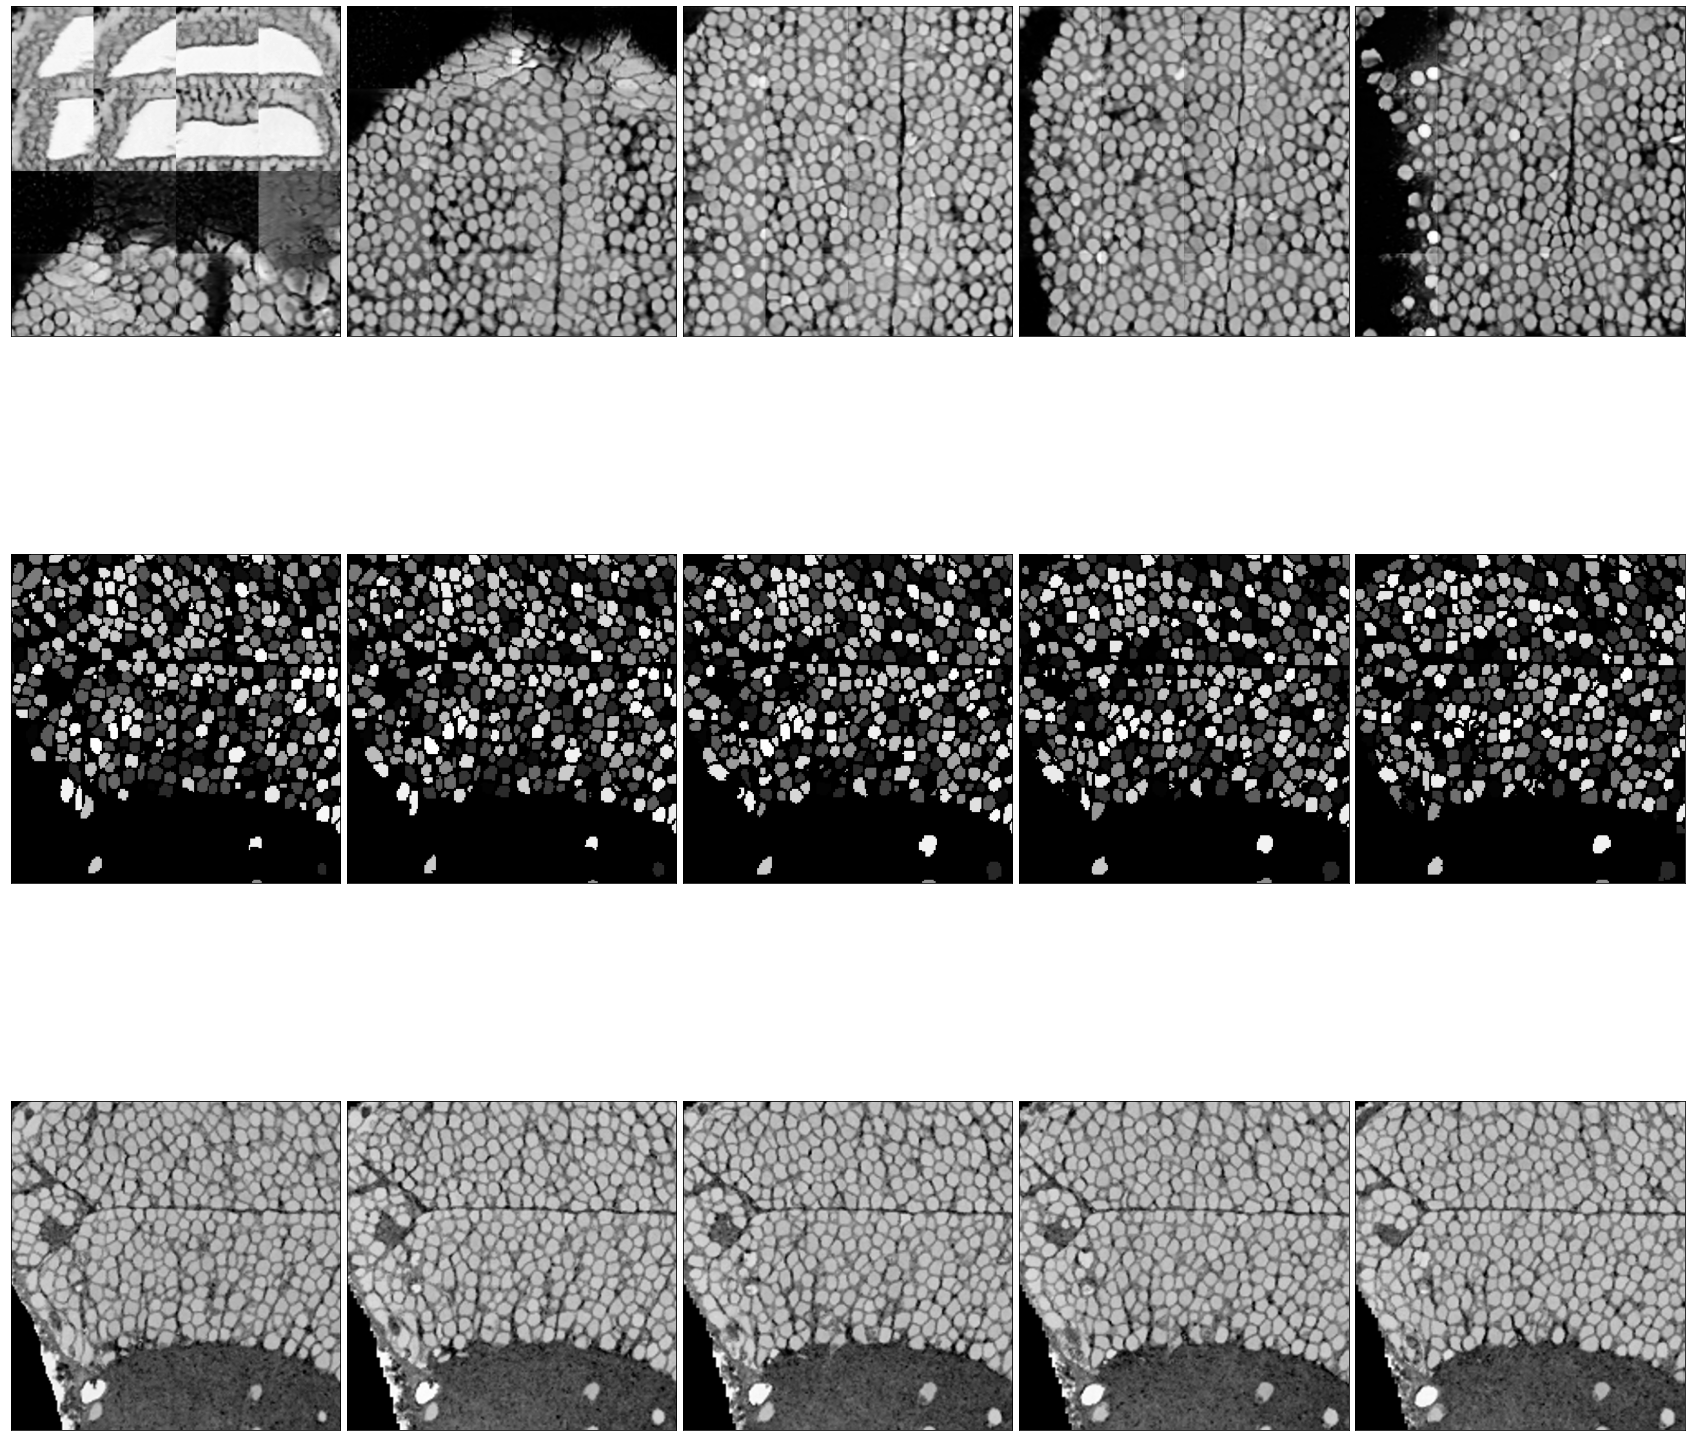

In [20]:
visual_check_h5s(os.path.join(save_files,"seg_exm2em_f0_img_patches_vol2.hdf5"), os.path.join(save_files, "seg_em2exm_f0_seg_patches.hdf5"), os.path.join(save_files,"seg_em2exm_f0_source_patches.hdf5") )

In [21]:
def tif_to_h5(orig_path, dest_path, insta=False):
    """ Takes a tiff file and converts it to a h5 file.
        
        Args:
            orig_path: Path to the tiff file
            dest_path: Path where to save the h5 file
    """
    with tifffile.TiffFile(orig_path) as tif, \
            h5py.File(dest_path, "w") as h5:
        tif_images = np.asarray([t.asarray() for t in tif.pages[:]])
        h5_dataset =  h5.create_dataset("main", data=tif_images)

In [41]:
tif_to_h5("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif",
         os.path.join(save_files, "seg_em2exm_f0_seg_patches.hdf5"))

In [42]:
tif_to_h5("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/em_3D_255_512_512.tif",
         os.path.join(save_files,"seg_em2exm_f0_source_patches.hdf5"))

(255, 512, 512) (255, 512, 512) (255, 512, 512)


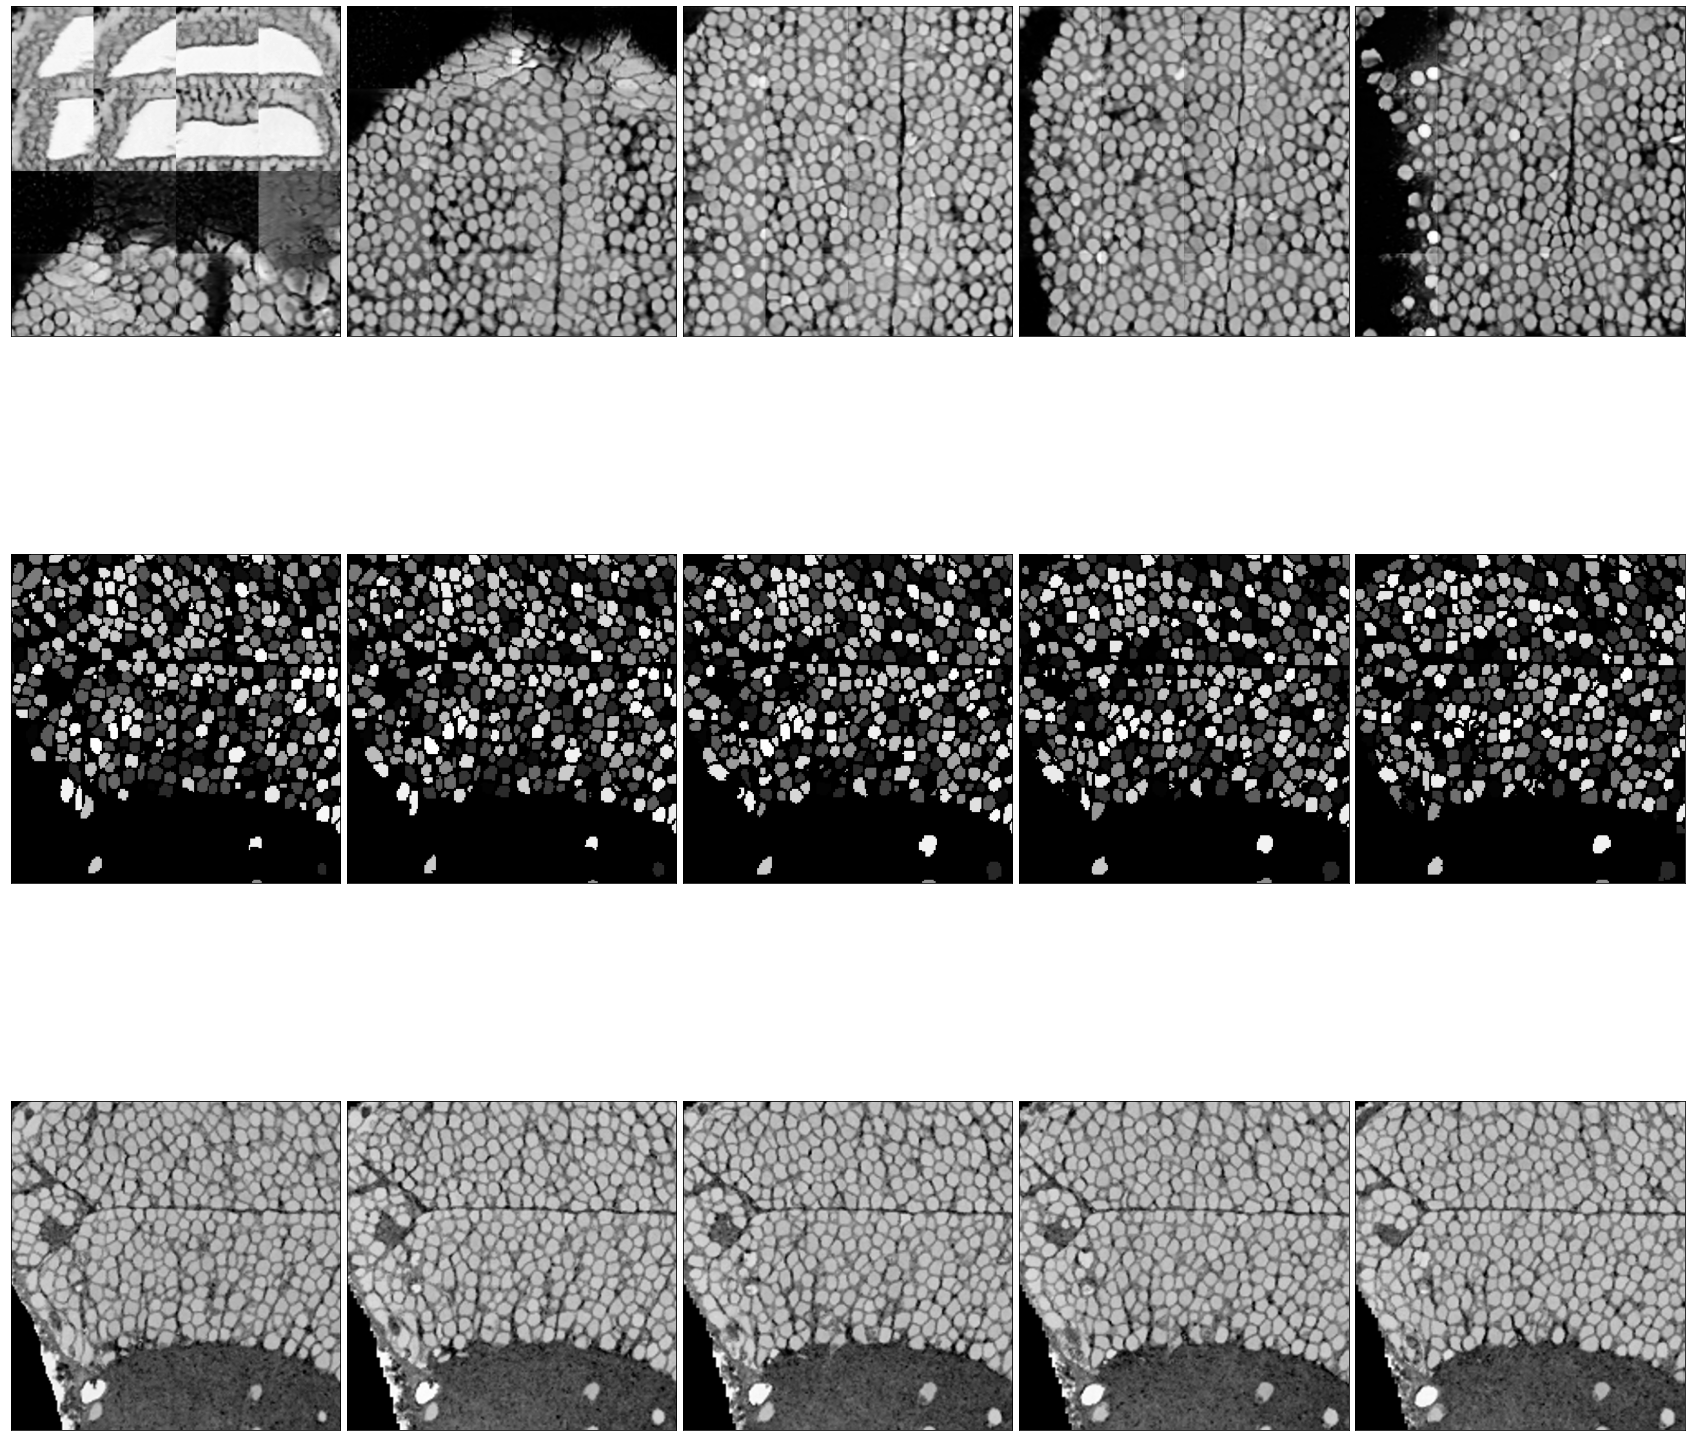

In [24]:
visual_check_h5s(os.path.join(save_files,"seg_exm2em_f0_img_patches_vol4.hdf5"), os.path.join(save_files, "seg_em2exm_f0_seg_patches.hdf5"), os.path.join(save_files,"seg_em2exm_f0_source_patches.hdf5") )

In [22]:
fp = h5py.File(os.path.join(save_files,"seg_exm2em_f0_img_patches_vol2.hdf5"), "r")
img = fp.get('main')
print(img.dtype)
print(np.max(img))
fp.close()
               

uint8
254
